# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

/home/tsion_w/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

# Specify the filename and variable names
filename = "SUSY.csv"
VarNames = ["signal", "l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", 
            "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
            "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

# Load the dataset
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [4]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [5]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

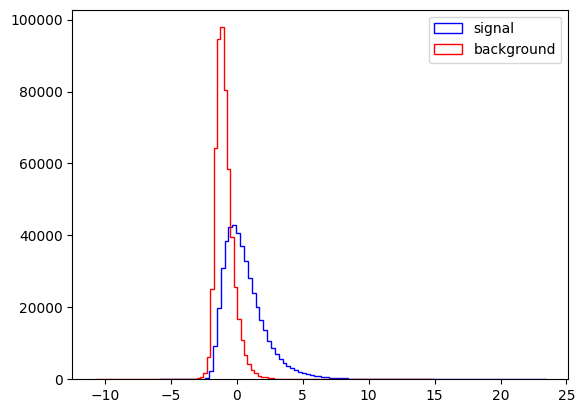

In [7]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

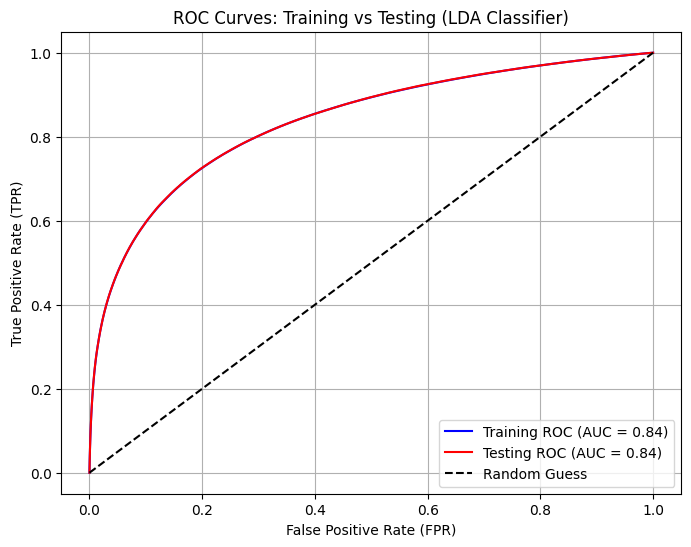

In [8]:
from sklearn.metrics import roc_curve, auc

# Compute ROC and AUC for the training sample
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC and AUC for the testing sample
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Testing ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')

# Add labels and legend
plt.title('ROC Curves: Training vs Testing (LDA Classifier)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The ROC curves for training (blue) and testing (red) samples overlap almost perfectly.
Both have an AUC of 0.84, indicating that the model performs equally well on training and testing data.
The overlap between the curves suggests that the classifier generalizes well to unseen data.
There is no significant bias observed between training and testing performance.

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

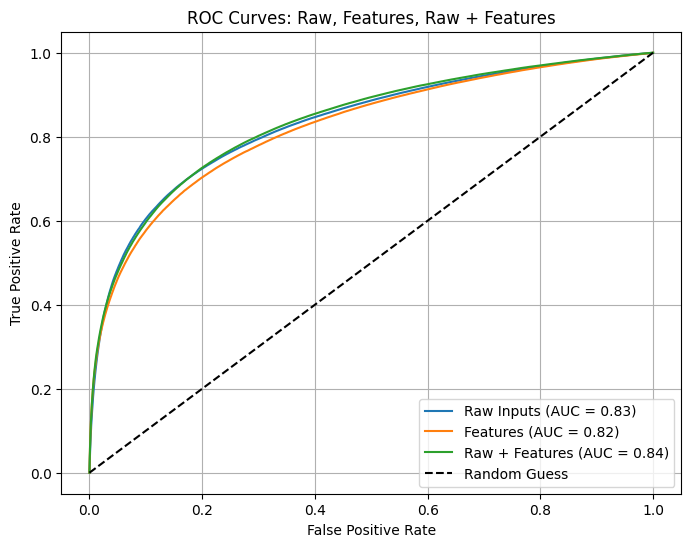

In [9]:
# Define raw and feature variable groups
RawNames = ["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames = list(set(VarNames[1:]).difference(RawNames))  # Exclude signal and raw variables

# Initialize a dictionary to store results
results = {}

# Function to train LDA and calculate ROC and AUC
from sklearn.metrics import roc_curve, auc

def train_and_evaluate(X_train, X_test, label):
    Fisher = DA.LinearDiscriminantAnalysis()
    Fisher.fit(X_train, y_Train)

    # Compute ROC and AUC for testing data
    fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_test))
    roc_auc = auc(fpr, tpr)
    results[label] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}

# Train and evaluate using raw inputs
X_Train_Raw = Train_Sample[RawNames]
X_Test_Raw = Test_Sample[RawNames]
train_and_evaluate(X_Train_Raw, X_Test_Raw, "Raw Inputs")

# Train and evaluate using features
X_Train_Features = Train_Sample[FeatureNames]
X_Test_Features = Test_Sample[FeatureNames]
train_and_evaluate(X_Train_Features, X_Test_Features, "Features")

# Train and evaluate using raw + features
X_Train_Raw_Features = Train_Sample[RawNames + FeatureNames]
X_Test_Raw_Features = Test_Sample[RawNames + FeatureNames]
train_and_evaluate(X_Train_Raw_Features, X_Test_Raw_Features, "Raw + Features")

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for label, result in results.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{label} (AUC = {result['auc']:.2f})")

# Add legend, labels, and title
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Raw, Features, Raw + Features")
plt.grid()
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

In [ ]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Classifier (SVC)": SVC(kernel="rbf", probability=True, random_state=42)
}

# Dictionary to store results
results_comparison = {}

# Function to train and evaluate each classifier
def evaluate_classifier(clf, name, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    results_comparison[name] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    return roc_auc

# Use raw + features as inputs for fair comparison
X_Train_Raw_Features = Train_Sample[RawNames + FeatureNames]
X_Test_Raw_Features = Test_Sample[RawNames + FeatureNames]

# Evaluate each classifier
for name, clf in classifiers.items():
    auc_score = evaluate_classifier(clf, name, X_Train_Raw_Features, y_Train, X_Test_Raw_Features, y_Test)
    print(f"{name}: AUC = {auc_score:.2f}")

# Plot ROC curves for all classifiers
plt.figure(figsize=(8, 6))
for name, result in results_comparison.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{name} (AUC = {result['auc']:.2f})")

# Add legend, labels, and title
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of Classifiers: ROC Curves")
plt.grid()
plt.show()

Logistic Regression: AUC = 0.86


#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compare_classifier_performance(classifier, classifier_name, X_train, y_train, X_test, y_test):
    # Define input types for comparison
    input_types = {
        "Raw": RawNames,
        "Features": FeatureNames,
        "Raw + Features": RawNames + FeatureNames
    }
    
    plt.figure(figsize=(8, 6))
    
    # Loop through each input type and evaluate
    for input_type, input_columns in input_types.items():
        # Subset the training and testing data
        X_train_subset = X_train[input_columns]
        X_test_subset = X_test[input_columns]
        
        # Train the classifier
        classifier.fit(X_train_subset, y_train)
        
        # Evaluate the classifier using ROC and AUC
        y_scores = classifier.predict_proba(X_test_subset)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f"{input_type} (AUC = {roc_auc:.2f})")
    
    # Add plot details
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Performance Comparison ({classifier_name})")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [ ]:
# Logistic Regression Example
log_reg = LogisticRegression(max_iter=1000, random_state=42)
compare_classifier_performance(log_reg, "Logistic Regression", Train_Sample, y_Train, Test_Sample, y_Test)

# Random Forest Example
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
compare_classifier_performance(rf_clf, "Random Forest", Train_Sample, y_Train, Test_Sample, y_Test)

# SVC Example
svc_clf = SVC(kernel="rbf", probability=True, random_state=42)
compare_classifier_performance(svc_clf, "Support Vector Classifier", Train_Sample, y_Train, Test_Sample, y_Test)


#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [ ]:
# Define the scenarios as in Lab 5
scenarios = {
    "1": (10, 100),
    "2": (100, 1000),
    "3": (1000, 10000),
    "4": (10000, 100000)
}

# Function to compute maximal significance
def compute_maximal_significance(classifier, X_test, y_test, scenarios):
    # Get decision function scores
    scores = classifier.decision_function(X_test)  # or predict_proba()[:, 1] for some classifiers
    
    # Sort scores and reverse for thresholds
    thresholds = np.sort(scores)[::-1]
    
    # True and predicted signals/background
    y_signal = (y_test == 1)
    y_background = (y_test == 0)
    
    max_significance = {}
    for name, (N_sig_expected, N_bkg_expected) in scenarios.items():
        # Initialize significance tracking
        best_sigma_S = 0
        best_threshold = None
        
        # Loop through thresholds
        for threshold in thresholds:
            # Count signal and background events above threshold
            N_S = np.sum(scores[y_signal] > threshold) / len(y_signal) * N_sig_expected
            N_B = np.sum(scores[y_background] > threshold) / len(y_background) * N_bkg_expected
            
            # Compute significance
            if N_S + N_B > 0:
                sigma_S = N_S / np.sqrt(N_S + N_B)
                # Update if better significance is found
                if sigma_S > best_sigma_S:
                    best_sigma_S = sigma_S
                    best_threshold = threshold
        
        # Store the results for this scenario
        max_significance[name] = {
            "Max Significance": best_sigma_S,
            "Optimal Threshold": best_threshold,
            "N_S": N_S,
            "N_B": N_B
        }
    
    return max_significance

# Compute maximal significance using the best classifier
best_classifier = LogisticRegression(max_iter=1000, random_state=42)  # Replace with the best classifier
best_classifier.fit(X_Train[RawNames + FeatureNames], y_Train)

# Compute significance
max_sig_results = compute_maximal_significance(best_classifier, X_Test[RawNames + FeatureNames], y_Test, scenarios)

# Display the results
import pandas as pd
results_df = pd.DataFrame(max_sig_results).transpose()
display(results_df)


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Compute TPR, FPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_Test, Fisher.decision_function(X_Test))

# Compute AUC
roc_auc = auc(fpr, tpr)

# Compute precision, recall, F1-score, and accuracy
y_Pred = Fisher.predict(X_Test)  # Predicted labels
precision = precision_score(y_Test, y_Pred)
recall = recall_score(y_Test, y_Pred)
f1 = f1_score(y_Test, y_Pred)
accuracy = accuracy_score(y_Test, y_Pred)

# Print the metrics
print(f"AUC: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (TPR): {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def evaluate_model_performance(classifier, scenarios, X_Test, y_Test, decision_function):
    # Evaluate base metrics
    fpr, tpr, thresholds = roc_curve(y_Test, decision_function)
    roc_auc = auc(fpr, tpr)

    # Predictions
    y_Pred = classifier.predict(X_Test)
    precision = precision_score(y_Test, y_Pred)
    recall = recall_score(y_Test, y_Pred)
    f1 = f1_score(y_Test, y_Pred)
    accuracy = accuracy_score(y_Test, y_Pred)

    # Evaluate for each scenario
    results = []
    for name, (N_sig, N_bkg) in scenarios.items():
        # Effective signal and background
        N_sig_prime = N_sig * recall
        N_bkg_prime = N_bkg * fpr[-1]  # FPR at threshold

        # Compute maximal significance
        if N_sig_prime + N_bkg_prime > 0:
            significance = N_sig_prime / np.sqrt(N_sig_prime + N_bkg_prime)
        else:
            significance = 0

        results.append({
            "Scenario": name,
            "N_sig": N_sig,
            "N_bkg": N_bkg,
            "Precision": precision,
            "Recall (TPR)": recall,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "AUC": roc_auc,
            "Maximal Significance": significance
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define scenarios
scenarios = {
    "1": (10, 100),
    "2": (100, 1000),
    "3": (1000, 10000),
    "4": (10000, 100000)
}

# Evaluate for the best method from Part 4c (e.g., Fisher)
decision_function = Fisher.decision_function(X_Test)
performance_table = evaluate_model_performance(Fisher, scenarios, X_Test, y_Test, decision_function)

# Display the results
display(HTML(performance_table.to_html(index=False)))